### Importing Libraries

In [1]:
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, Variable, ParticleFile
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

### Verifying the structure and dimentions of the data files

In [2]:
# Open the SSC dataset
ssc_ds = xr.open_dataset("Model_Outputs\predicted_ssc_data.nc")

# Print the SSC dataset
print("SSC Dataset:\n")
print(ssc_ds)
print("=" * 125)

# Open the wind dataset
# wind_ds = xr.open_dataset("Data/Processed_Wind_Data.nc")

# Print the wind dataset
# print("\nWind Dataset:\n")
# print(wind_ds)
# print("=" * 125)

# Close datasets after inspection
ssc_ds.close()
# wind_ds.close()

SSC Dataset:

<xarray.Dataset>
Dimensions:  (time: 56, lat: 25, lon: 22)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-15T12:00:00 2023-10-16 ... 2023-11-12
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
Data variables:
    u        (time, lat, lon) float32 ...
    v        (time, lat, lon) float32 ...


### Load Shapefile and Extract Coastline Boundaries

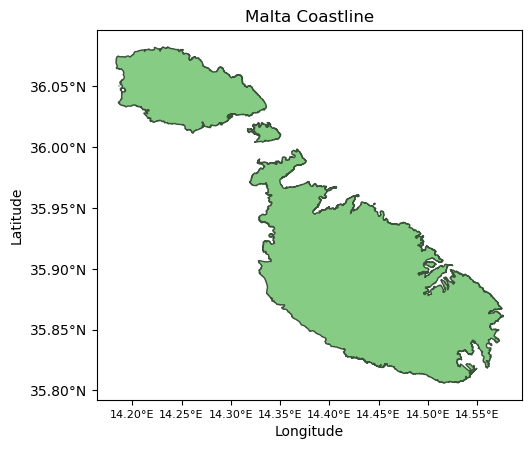

In [3]:
# Load the shapefile
shapefile_path = 'Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to WGS 84 CRS if it's not already
gdf = gdf.to_crs(epsg=4326)

# Plot the shapefile with latitude and longitude labels
gdf.plot(color='#86CC85', edgecolor='#3B533B')
plt.title('Malta Coastline')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Format the axis labels to show degrees
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°E'.format(val)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°N'.format(val)))

# Make the x-axis tick labels smaller
plt.gca().tick_params(axis='x', labelsize=8)  # Adjust fontsize to your preference

plt.show()

### Load Shapefile and Extract Coastline Boundaries

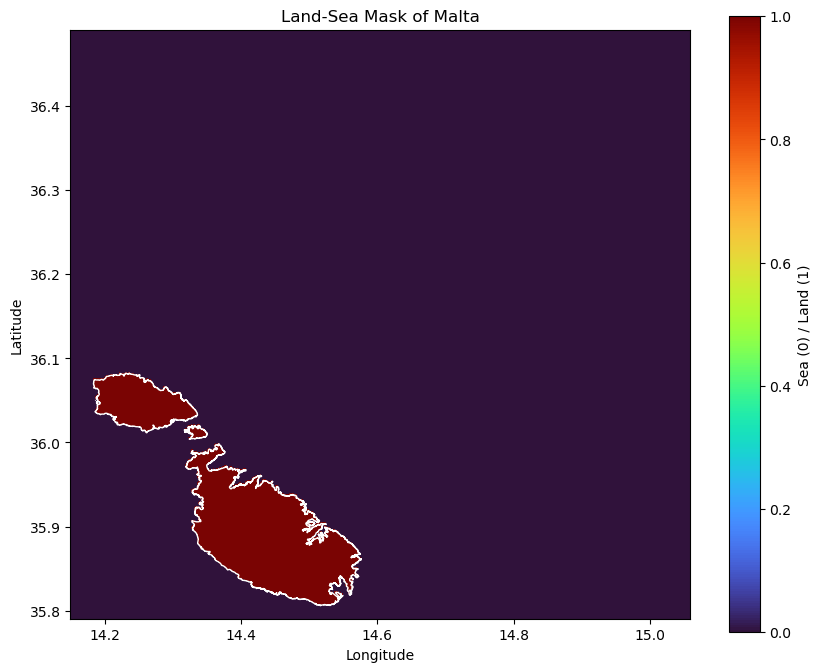

In [4]:
# Reproject to geographic coordinates (WGS 84)
gdf = gdf.to_crs(epsg=4326)

# Simulation bounds
lon_min, lat_min, lon_max, lat_max = 14.15, 35.79, 15.06, 36.49

# Define a finer resolution in kilometers
resolution_km = 0.1  # Finer resolution 

# Calculate the distance in degrees for the given resolution
mean_lat = (lat_min + lat_max) / 2
km_per_degree = np.cos(mean_lat * np.pi / 180) * 111.32  # Approximate conversion factor at this latitude
resolution_degrees = resolution_km / km_per_degree

# Calculate the number of grid cells at this new resolution
num_lons = int(np.ceil((lon_max - lon_min) / resolution_degrees))
num_lats = int(np.ceil((lat_max - lat_min) / resolution_degrees))

# Create the transformation from lat/lon to the grid
transform = rasterio.transform.from_origin(lon_min, lat_max, resolution_degrees, resolution_degrees)

# Rasterize the shapefile
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(num_lats, num_lons),
    transform=transform,
    fill=0,  # Fill value for 'sea'
    all_touched=True
)

# Generate the grid of longitude and latitude values
lons = np.linspace(lon_min, lon_max, num_lons, endpoint=False)
lats = np.linspace(lat_max, lat_min, num_lats, endpoint=False)[::-1]  # Start from max latitude to min latitude

# Create an xarray Dataset for the land-sea mask
ds = xr.Dataset(
    {
        'land_sea_mask': (['lat', 'lon'], raster)
    },
    coords={
        'lon': lons,
        'lat': lats  
    }
)

# Save the dataset to a NetCDF file
nc_filename = "Data/land_sea_mask/land_sea_mask_malta.nc"
ds.to_netcdf(nc_filename)

# Plot the land-sea mask for verification
plt.figure(figsize=(10, 8))
plt.pcolormesh(lons, lats[::-1], raster, cmap='turbo')
plt.colorbar(label='Sea (0) / Land (1)')
plt.title('Land-Sea Mask of Malta')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the shapefile to verify alignment
gdf.plot(ax=plt.gca(), color='none', edgecolor='white')

plt.show()

### Creating a FieldSet

In [5]:
fieldset = FieldSet.from_netcdf(
    filenames={
        "U": "Model_Outputs\predicted_ssc_data.nc",
        "V": "Model_Outputs\predicted_ssc_data.nc",
        # "U_wind": "Data/Processed_Wind_Data.nc",
        # "V_wind": "Data/Processed_Wind_Data.nc"
    },
    variables={
        "U": "u",
        "V": "v",
        # "U_wind": "u10",
        # "V_wind": "v10"
    },
    dimensions={
        "U": {"lon": "lon", "lat": "lat", "time": "time"},
        "V": {"lon": "lon", "lat": "lat", "time": "time"},
        # "U_wind": {"lon": "longitude", "lat": "latitude", "time": "time"},
        # "V_wind": {"lon": "longitude", "lat": "latitude", "time": "time"}
    },
    allow_time_extrapolation=True
)

# Load the land-sea mask data
landsea_data = xr.open_dataset("Data/land_sea_mask/land_sea_mask_malta.nc")

# Add the land-sea mask as a Field to the FieldSet
fieldset.add_field(Field('land_sea_mask', 
                         data=landsea_data['land_sea_mask'].values, 
                         lon=landsea_data['lon'].values, 
                         lat=landsea_data['lat'].values, 
                         mesh='spherical', 
                         interp_method='nearest'))

### Initializing the Particles

In [6]:
# Define polygon boundaries
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 15.06,  
    'min_lat': 35.79,  
    'max_lat': 36.49   
}

# Number of particles to release along each axis
num_particles_lon = 25  # example value, adjust as necessary
num_particles_lat = 25  # example value, adjust as necessary

# Generate evenly spaced positions across the domain
lon_release = np.linspace(boundaries['min_lon'], boundaries['max_lon'], num_particles_lon)
lat_release = np.linspace(boundaries['min_lat'], boundaries['max_lat'], num_particles_lat)

# Use meshgrid to create a grid of release points
lon_release, lat_release = np.meshgrid(lon_release, lat_release)
lon_release = lon_release.flatten()
lat_release = lat_release.flatten()

### Define Simulation Parameters

In [7]:
# Define number of days for the simulation
runtime = timedelta(days=28)  

# Option 2: Timestep that aligns with your data intervals (e.g., 30 minutes or 1 hour)
dt = timedelta(hours=12)

# Option 3: If you want to use the exact timestep as your data
# dt = timedelta(hours=12)  # if your data interval is 12 hours

### Custom Kernels & Executing the Simulation

In [8]:
# def CheckOutOfBounds(particle, fieldset, time):
#     if particle.state == StatusCode.ErrorOutOfBounds:
#         particle.delete()

def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()
        
class ReflectiveParticle(JITParticle):
    # Adding variables for previous positions
    prev_lon = Variable('prev_lon', initial=fieldset.U.grid.lon[0])  # Initialize with the first longitude 
    prev_lat = Variable('prev_lat', initial=fieldset.U.grid.lat[0])  # Initialize with the first latitude 
    elapsed_time = Variable('elapsed_time', initial=0.)  # Elapsed time in seconds
    
# Custom kernel to update the elapsed time
def UpdateElapsedTime(particle, fieldset, time):
    particle.elapsed_time += math.fabs(particle.dt) / (3600 * 24)  # Convert seconds to days
    
def UpdatePreviousPosition(particle, fieldset, time):
    # Update the previous position with the current position before moving
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

def ReflectOnLand(particle, fieldset, time):
    if fieldset.land_sea_mask[particle] == 1:
        # Reflect the particle's position
        particle.lon = particle.prev_lon
        particle.lat = particle.prev_lat
          
# Create a ParticleSet with JITParticle positioned near the edges
pset = ParticleSet(fieldset=fieldset, pclass=ReflectiveParticle, lon=lon_release, lat=lat_release)

# Define a custom output file that will store the elapsed_time for each particle
class MyParticleFile(ParticleFile):
    def __init__(self, *args, **kwargs):
        super(MyParticleFile, self).__init__(*args, **kwargs)

    def write(self, pset, time):
        """Write out the elapsed_time for each particle"""
        super(MyParticleFile, self).write(pset, time)
        for particle in pset:
            self.dataset.variables['elapsed_time'][self.idx] = particle.elapsed_time
        self.idx += 1

# Execute the simulation
output_file = pset.ParticleFile(name="Lagrangian_Output/predicted_debris_simulation_output.zarr", outputdt=timedelta(hours=12))

pset.execute(
    AdvectionRK4 + 
    pset.Kernel(UpdatePreviousPosition) + 
    pset.Kernel(ReflectOnLand) +
    pset.Kernel(UpdateElapsedTime) +
    #pset.Kernel(CheckOutOfBounds) + 
    pset.Kernel(CheckError),
    runtime=runtime,
    dt=dt,
    output_file=output_file,
) 

INFO: Output files are stored in Lagrangian_Output/predicted_debris_simulation_output.zarr.
100%|██████████| 2419200.0/2419200.0 [00:38<00:00, 62742.15it/s]


In [9]:
# # Load the simulation output
# ds = xr.open_zarr("Lagrangian_Output/predicted_debris_simulation_output.zarr")

# # Check the first and last positions of particles to ensure they have moved
# first_positions = ds.isel(obs=0)  # First timestep
# last_positions = ds.isel(obs=-1)  # Last timestep

# print("Diagnostics: Particle movement from first to last timestep")
# for particle_id in ds['trajectory'].values:  # Ensure we iterate over the values
#     # Load the data into memory and then access the scalar values
#     first_lon = first_positions.sel(trajectory=particle_id).lon.values.item()
#     first_lat = first_positions.sel(trajectory=particle_id).lat.values.item()
#     last_lon = last_positions.sel(trajectory=particle_id).lon.values.item()
#     last_lat = last_positions.sel(trajectory=particle_id).lat.values.item()
    
#     print(f"Particle {particle_id}:")
#     print(f"  Start Lon = {first_lon}, Start Lat = {first_lat}")
#     print(f"  End Lon = {last_lon}, End Lat = {last_lat}")
#     print(f"  Distance moved: Lon = {last_lon - first_lon}, Lat = {last_lat - first_lat}\n")

### Visualise

In [14]:
# Load the simulation output
ds = xr.open_zarr("Lagrangian_Output/predicted_debris_simulation_output.zarr")

# Load the shapefile with the map of Malta
malta_map = gpd.read_file('Data/land_sea_mask/MaltaCoastline.shp')
malta_map = malta_map.to_crs(epsg=4326)

# Define the geographic boundaries for the plot
extent = [14.15, 15.06, 35.79, 36.49]

# Turn off interactive plotting
plt.ioff()

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Add the map of Malta
malta_map.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Add other map features
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define and set custom tick labels without degrees for longitude and latitude
lon_ticks = np.linspace(extent[0], extent[1], 5) 
lat_ticks = np.linspace(extent[2], extent[3], 5) 

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

# Add labels to the x and y axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Initialize scatter plot with empty data
scatter = ax.scatter([], [], s=1, c="purple", marker='o', transform=ccrs.PlateCarree())

# Initialize a text element to display the number of days passed
day_text = ax.text(0.01, 0.95, '', transform=ax.transAxes, color='black')

simulation_start_date = pd.to_datetime('2021-01-01')

# Initialize a text element at the figure level to display the number of days passed
day_text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize='large', color='black')

# Function to update the scatter plot and text at each frame
def update(frame):
    time_step_data = ds.isel(obs=frame)
    scatter.set_offsets(np.vstack((time_step_data.lon.values, time_step_data.lat.values)).T)
    
    # Calculate the number of days since the start of the simulation
    current_time_str = time_step_data.time.values[0]  # Assuming this is a string
    current_time = pd.to_datetime(current_time_str)
    num_days = (current_time - simulation_start_date).days
    day_text.set_text(f"No. of days: {num_days}")  # Update the figure-level text

    return scatter, day_text

# Adjust the frames parameter to ensure each frame represents one day
total_days = ds.sizes['obs'] 

# Create animation
ani = FuncAnimation(fig, update, frames=total_days, interval=100, blit=False)

# Set limit for the animation (in MB)
mpl.rcParams['animation.embed_limit'] = 300

# To save the animation as a GIF file
ani.save('Videos/predicted_particle_trajectories.gif', writer='pillow')

### Animation

In [15]:
HTML(ani.to_jshtml())